## 専門知識労働者
- 保険テクノロジー企業である Insurellm の従業員が使用する、専門知識を持つナレッジ ワーカーである質問応答エージェント。エージェントは正確である必要があり、ソリューションは低コストである必要があります。
- このプロジェクトでは、RAG（検索拡張生成）を使用して、質問/回答アシスタントが高い精度を確保します。ココ、3つめの実装では、RAGにおけるベクトル化とストアへの格納を試行します。

In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
!pip install scikit-learn
!pip install plotly

In [3]:
# langchain、Chroma、plotly のインポート

# langchain
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

# VDBサポート (langchain_chroma)
from langchain_chroma import Chroma

# 可視化関連（plotly）
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [4]:
# 価格は重要な要素（と言う建付け）なので、低コストモデルを採用
MODEL = "gpt-4o-mini"

# コレはVDBのChromaのDB名
db_name = "vector_db"

In [5]:
# .envファイルから環境変数をロード
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [6]:
# langChain のローダーを使用してKBのすべてのサブフォルダ内のすべてのドキュメントを読み取りリスト化
# 余談：メタデータは、DirectoryLoader および TextLoader によって生成され、そこにカスタムの属性、doc_typeを追加している。

folders = glob.glob("knowledge-base/*")

# 一部のユーザーに必要な修正を提供してくれた、コース受講生のCGとJon Rに感謝します。
text_loader_kwargs = {'encoding': 'utf-8'}
# それでもうまくいかない場合は、Windowsユーザーの中には次の行のコメントを解除する必要があるかもしれません。
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

# ご注意ください：

次のセルでは、テキストをチャンクに分割します。

- 2人の学生が、次のセルがコンピューターをクラッシュさせたことを教えてくれました。  
- Chunk_sizeを1,000から2,000に変更し、Chunk_overlapを200から400に変更することで修正することができました。  
- これは必須ではありません。しかし、それがあなたに起こったら、その変更をしてください！  
-（Langchainは、チャンクが1,000を超えることについて警告を発する可能性があることに注意してください - これは安全に無視できます）。

_この貴重な貢献についてSteven WとNir Pに感謝します。_

In [7]:
# テキストを200文字の重複部分を持たせた1000文字ごとのチャンク（かたまり）に分割
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# document も chunk も LangChain の Document クラス
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [8]:
# チャンク・リストの長さ
len(chunks)

123

In [9]:
# chunks に含まれるすべての要素から doc_type メタデータを抽出し、重複を除いた種類を一覧表示
# ココでは、従業員、契約、製品、会社などの属性（元はフォルダ名）が表示されるハズ
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: products, employees, company, contracts


## 埋め込みのサイドノート、および「Auto-Encoding LLM」

テキストの各塊を、埋め込みとして知られるテキストの意味を表すベクトルにマッピングします。

OpenAIはこれを行うためのモデルを提供します。これをLangchainコードでAPIを呼び出すことで使用します。

このモデルは、完全な入力が与えられた出力を生成する「Auto-Encoding LLM」（要するに符号化するLLM）の例です。
「Auto-Regressive LLMs」（要するに次単語予測するLLM）として知られている今日説明した他のすべてのLLMとは異なり、過去のコンテキストのみに基づいて将来のトークンを生成します。

「Auto-Encoding LLM」の別の例は、GoogleのBertです。「埋め込み」に加えて「分類」に使用されることもよくあります。

### サイドノート
- 第8週には、RAGおよびベクトルの埋め込みに戻り、OSS Embeddingsを使用して、データがコンピューターを離れることはありません。
- これは、エンタープライズシステムとデータが内部を維持する必要がある場合に重要な考慮事項です。

In [10]:
# 各チャンクに埋込ベクトルを関連付けるVDBに格納
# Chroma は SQLite ベースの人気のOSS VDB

embeddings = OpenAIEmbeddings()

# Huggingfaceのフリーのベクトル埋め込みを使用したい場合
# 次と、embeddings = OpenAIEmbeddings() を交換します：

# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [11]:
# Chroma DataStoreがすでに存在するかどうかを確認してください - もしそうなら、コレクションを削除してゼロから始める

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [12]:
# Chroma VectorStoreを作成してください！

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [13]:
# 1つのベクトルを取得して、それが持っている次元数を表示

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 1,536 dimensions


## ベクトルストアの視覚化

- ドキュメントとその埋め込みベクトルを見て、何が起こっているのかを確認しましょう。
- 分類問題でもよく見た感じの散布図。確かに「Auto-Encoding LLM」は「分類」でも使用できそう。

In [14]:
# プレウォーク

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

In [15]:
# Graph表示に設定が必要らしいので
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

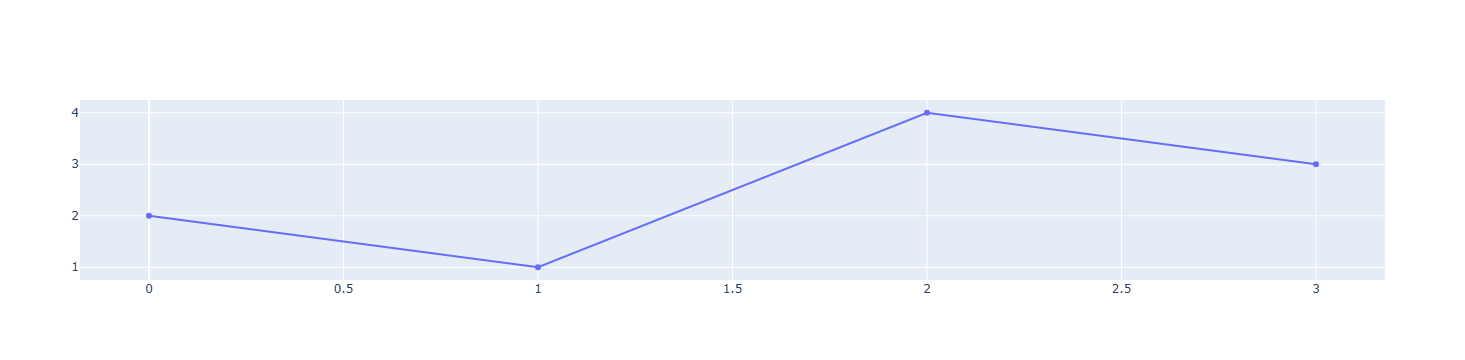

In [16]:
# Graph表示の最小限のテスト
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(y=[2, 1, 4, 3]))
fig.show()

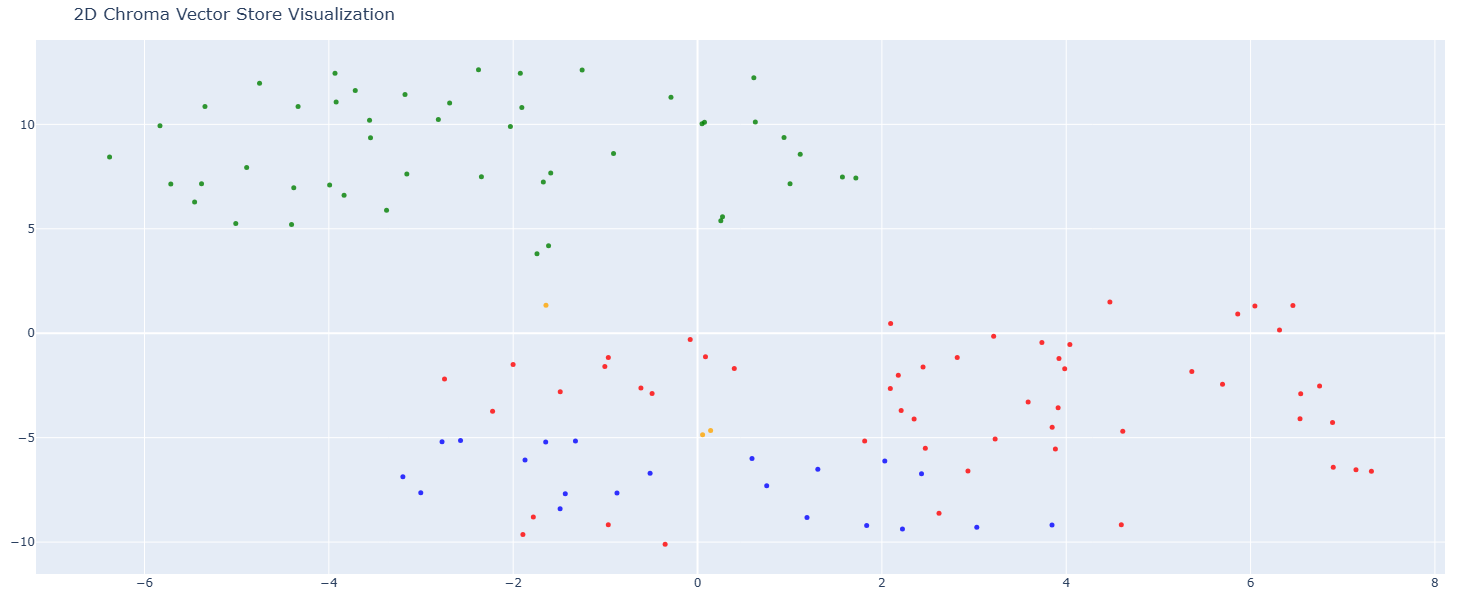

In [17]:
# 人間は、2Dで物事を視覚化する方が簡単と感じるので
# T-SNEを使用して、ベクターの寸法を2Dに減らします
# （t分配された確率的隣接埋め込み）

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# 2D散布図を作成します
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

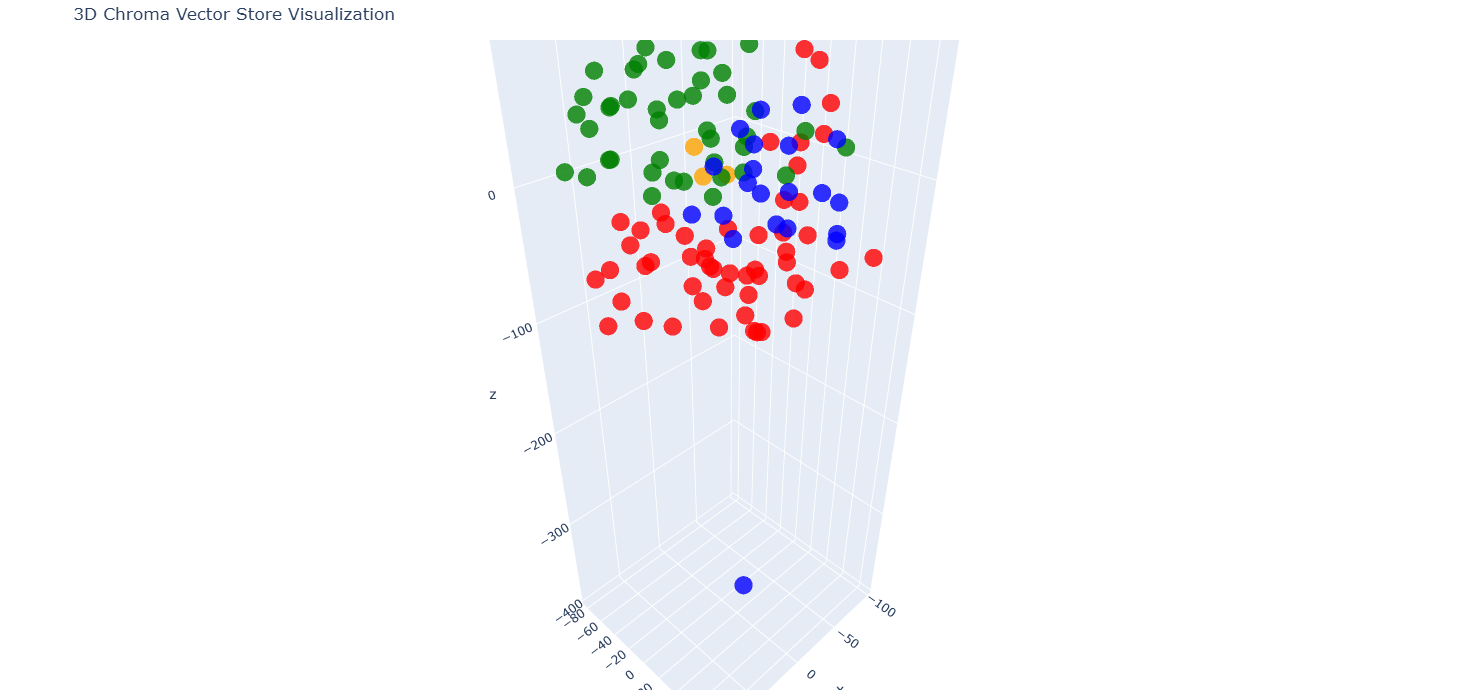

In [18]:
# 3Dを試してみましょう！

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# 3D散布図を作成します
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()